# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
plt.rcParams["figure.figsize"] = 10, 8
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return 2 * np.sin(w) * np.cos(w)
    

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

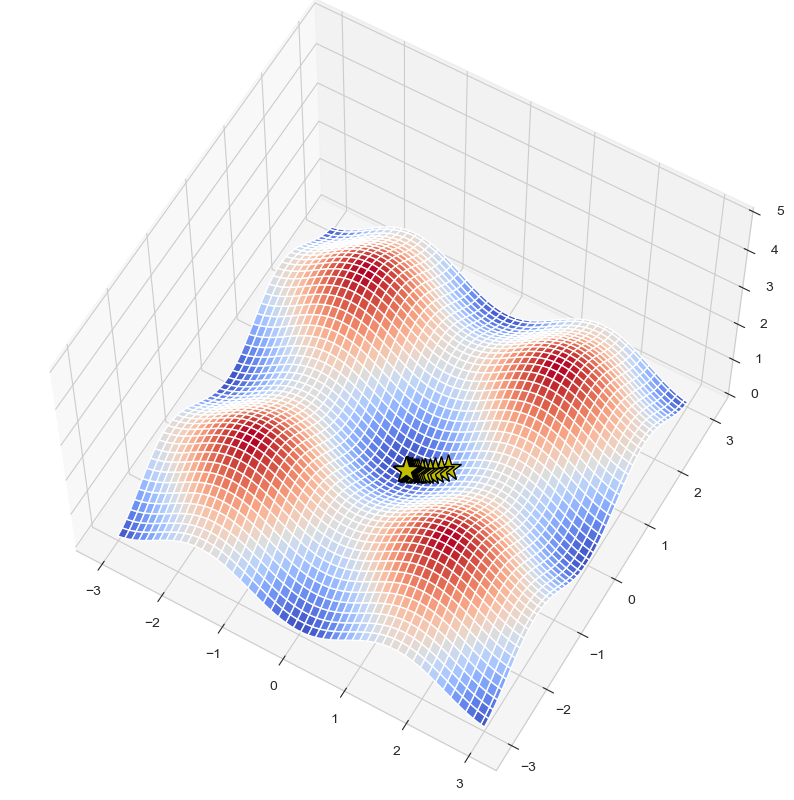

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

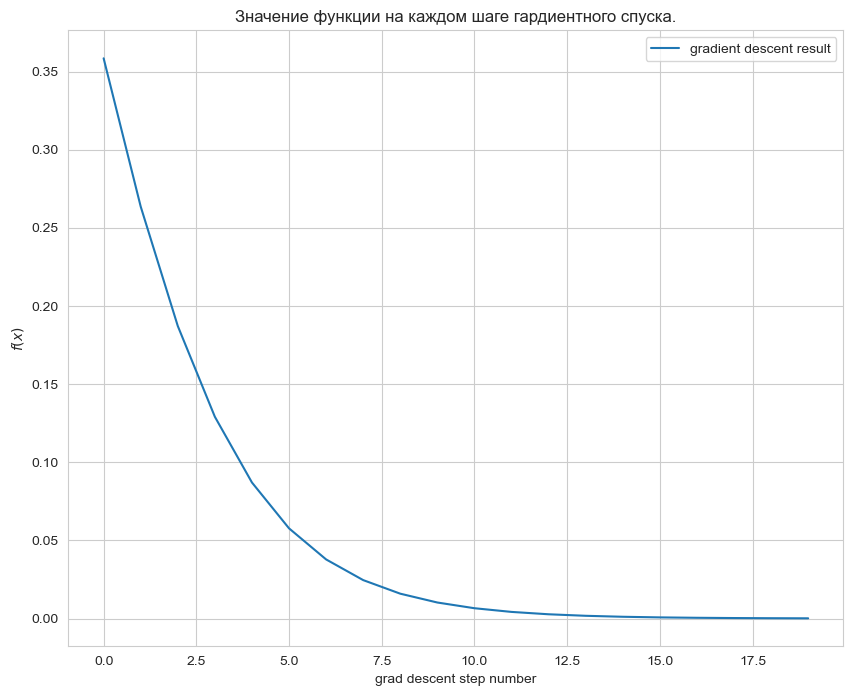

In [9]:
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    mse_func = np.sum((y_true - y_pred)**2) / y_pred.shape[0]
    return mse_func


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    mse_grad_f = 2 / y_pred.shape[0] * (X.T @ (y_pred - y_true))
    return mse_grad_f


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

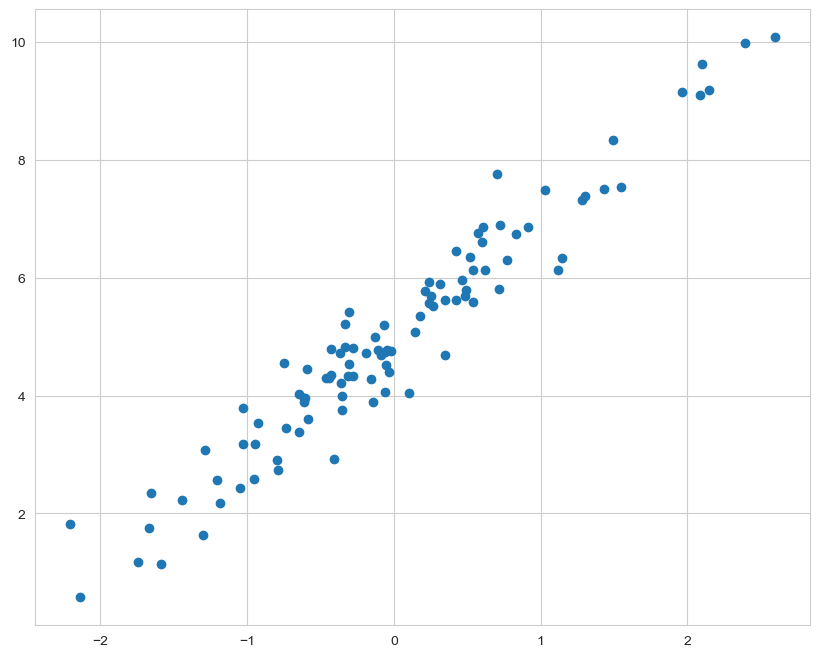

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

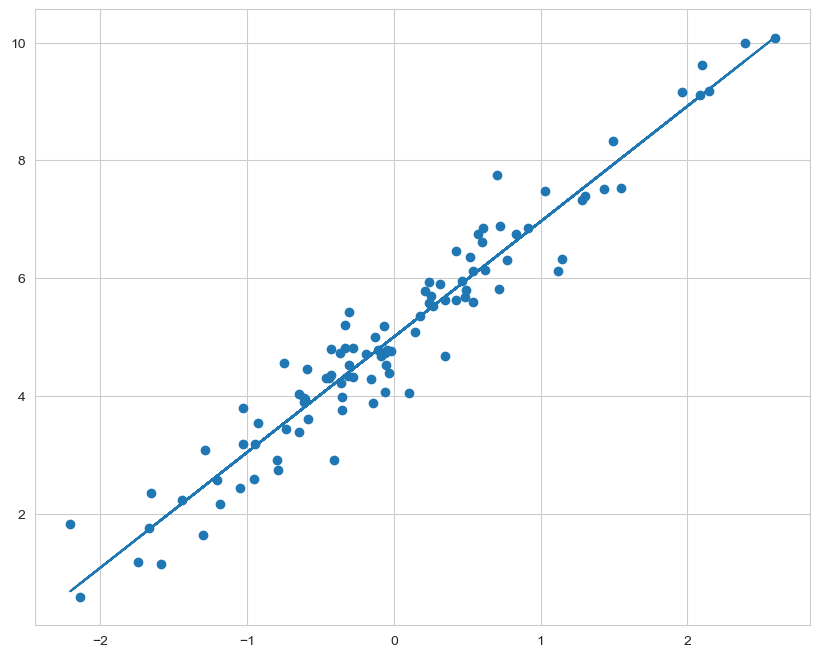

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

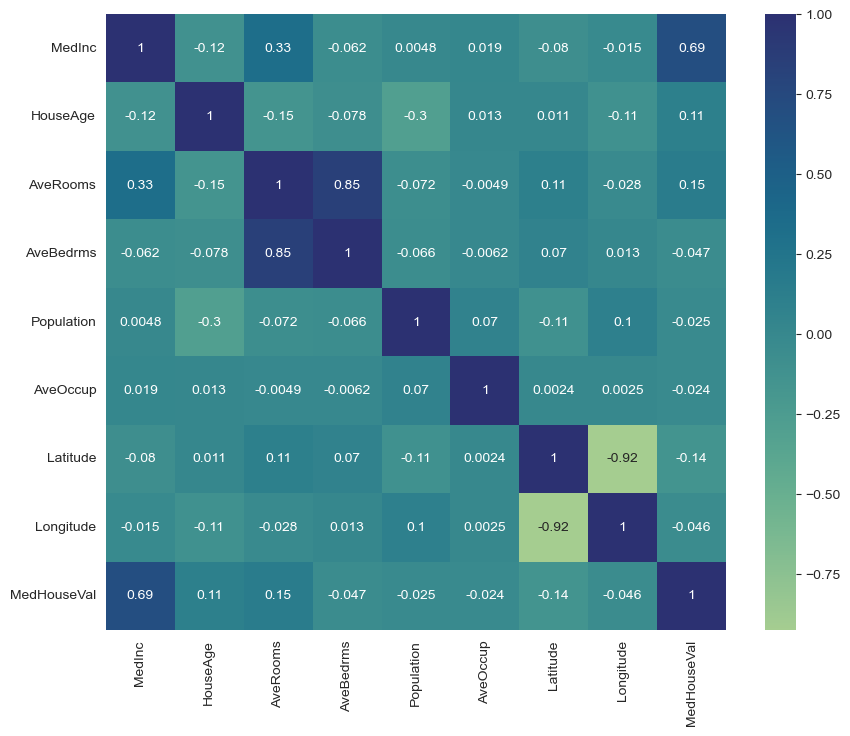

In [20]:
merged_data = X.join(pd.DataFrame(y))

#plt.figure(figsize=(7,5.5))
sns.heatmap(merged_data.corr(), annot=True, cmap="crest", fmt='.2g');

В данных есть зависимые признаки: AveRooms-AveBedrooms (коэф корреляции 0.85) и Latitude-Longitude (-0.92). Скорее всего, надо будет убрать ряд признаков. Но сперва посмотрим, что получится, если оставить все, как есть.

### EDA

In [21]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Нужна стандартизация, категориальных переменных нет.

Ваш ход:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.1)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [24]:
X_train_standarted = scaler.transform(X_train)
X_test_standarted = scaler.transform(X_test)

In [25]:
print('Before standartization: ')
for col_name in list(X_train):
    print(f'{col_name}: mean = {np.mean(X_train[col_name])}; std = {np.std(X_train[col_name])}')   

Before standartization: 
MedInc: mean = 3.870791026055145; std = 1.8974900330491333
HouseAge: mean = 28.618055555555557; std = 12.584954855922222
AveRooms: mean = 5.4319814452580975; std = 2.542048078320804
AveBedrms: mean = 1.097880035888609; std = 0.4919968478192502
Population: mean = 1427.58387166236; std = 1136.4090104943034
AveOccup: mean = 3.0873964812105488; std = 10.944106725399543
Latitude: mean = 35.62726582687322; std = 2.1343941997388334
Longitude: mean = -119.56515826873384; std = 2.002039385166318


In [26]:
print('After standartization: ')
counter = 0
for col_name in list(X_train):
    print(f'{col_name}: mean = {np.mean(X_train_standarted[ : , counter])}; std = {np.std(X_train_standarted[ : , counter])}')
    counter += 1

After standartization: 
MedInc: mean = -1.9010537234752896e-16; std = 0.9999999999999999
HouseAge: mean = -1.2048932050195497e-16; std = 1.0
AveRooms: mean = 2.1496824800666252e-16; std = 0.9999999999999999
AveBedrms: mean = -1.5309793819335708e-16; std = 1.0
Population: mean = -1.5300231174851425e-18; std = 0.9999999999999998
AveOccup: mean = -5.469832645009385e-17; std = 1.0
Latitude: mean = 6.973080357938537e-16; std = 1.0
Longitude: mean = -5.564694078293464e-15; std = 1.0


### Построение модели линейной регрессии 

In [27]:
regression = LinearRegression()
regression.fit(X_train_standarted, y_train)

y_pred = regression.predict(X_test_standarted)

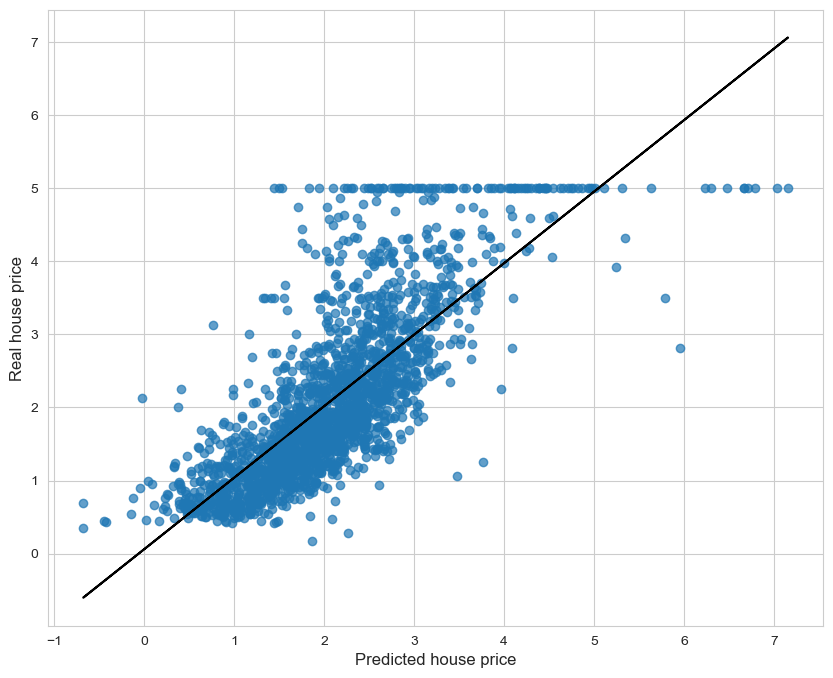

In [28]:
a, b = np.polyfit(y_pred, y_test, 1)

#fig = plt.figure(figsize=(10,8))
plt.scatter(y_pred, y_test, alpha=0.7) # x- predicted_price, y- real_price
plt.plot(y_pred, a * y_pred + b, color='black')
plt.xlabel('Predicted house price', size=12)
plt.ylabel('Real house price', size=12);

In [29]:
print('Значения коэффициентов по признакам:')
counter = 0

for name in feature_names:
    print(f'{name} = {round(regression.coef_[counter], 3)}')
    counter += 1

Значения коэффициентов по признакам:
MedInc = 0.828
HouseAge = 0.119
AveRooms = -0.263
AveBedrms = 0.307
Population = -0.005
AveOccup = -0.039
Latitude = -0.898
Longitude = -0.866


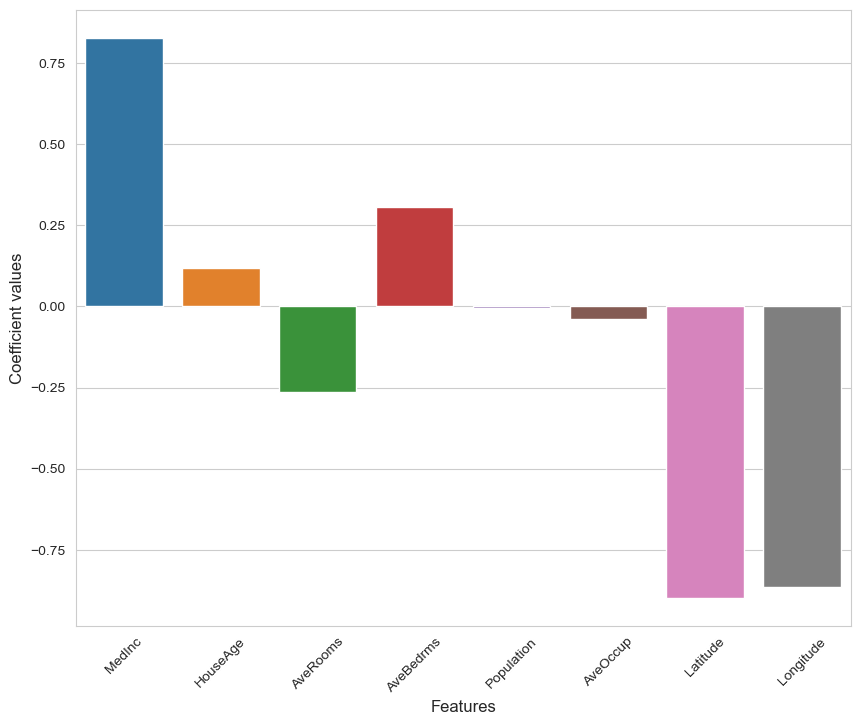

In [30]:
#fig = plt.figure(figsize=(8,5))
sns.barplot(x=feature_names, y=regression.coef_)
plt.ylabel('Coefficient values', size=12)
plt.xlabel('Features', size=12)
plt.xticks(rotation=45);

### Оценка качества модели

In [31]:
# r^2
r_squared = r2_score(y_test, y_pred)

# mse
mse = mean_squared_error(y_test, y_pred)

print(f'R^2 = {round(r_squared, 2)}; MSE = {round(mse, 2)}')

R^2 = 0.59; MSE = 0.54


Низкий $R^2$, с помощью данной модели можно объяснить только 59 % наблюдаемой вариабельности. С MSE не наблюдается проблем, значение близко к 0. Попробуем "почистить" наши данные. Для удобства заготовим pipeline.

In [32]:
lin_regr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])                            

Меня смущает в данных, что предсказание для реальной цены (y_true) равной 5.0 модель выполняет достаточно плохо. Возможно, это связано с тем, что для хорошего предсказания модели нужны дополнительные признаки (осознанные), либо данная цена является априори максимальной. В любом случае, можно попробовать убрать эти данные и посмотреть, что получится:)

### Удаление наблюдений, не объяснимых данной моделью (когда стоимость дома >= 5.0)

In [33]:
y = pd.DataFrame(y)
idx_no_max_price = y.loc[y['MedHouseVal'] < 5.0].index.tolist()
y_no_max_price = y.iloc[idx_no_max_price]
X_no_max_price = X.iloc[idx_no_max_price]
X_no_max_price.shape

(19648, 8)

In [34]:
X_train_no_max_price, X_test_no_max_price, y_train_no_max_price, y_test_no_max_price = train_test_split(X_no_max_price, y_no_max_price,
                                                    random_state=SEED,
                                                    test_size=0.1)

In [35]:
lin_regr_pipeline.fit(X_train_no_max_price, y_train_no_max_price)
y_pred_no_max_price = lin_regr_pipeline.predict(X_test_no_max_price)

In [36]:
y_pred_no_max_price = np.reshape(y_pred_no_max_price, (1965,), order='F')

In [37]:
y_test_no_max_price['MedHouseVal'].shape

(1965,)

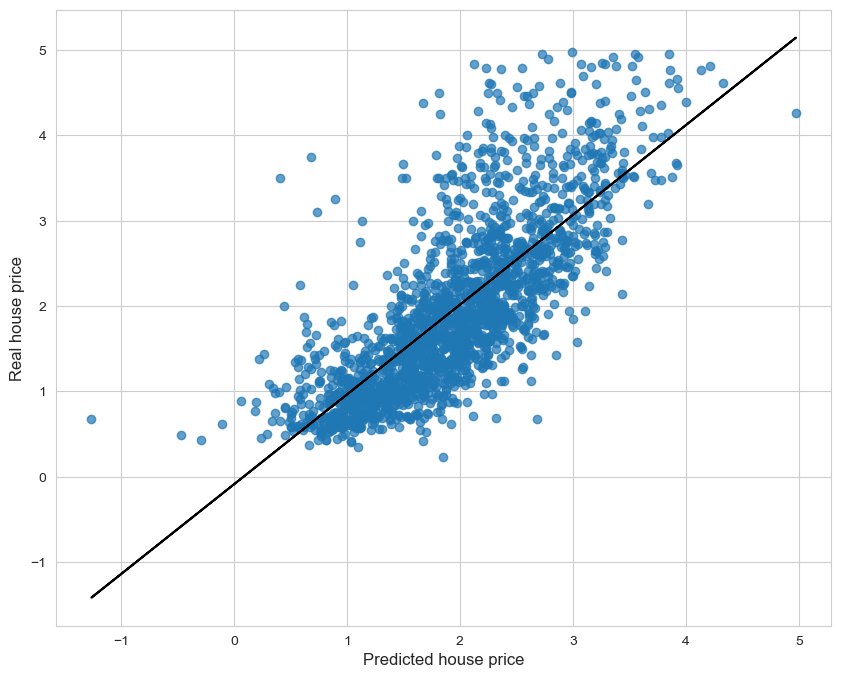

In [38]:
a, b = np.polyfit(y_pred_no_max_price, y_test_no_max_price['MedHouseVal'], 1)

plt.scatter(y_pred_no_max_price, y_test_no_max_price['MedHouseVal'], alpha=0.7) # x- predicted_price, y- real_price
plt.plot(y_pred_no_max_price, a * y_pred_no_max_price + b, color='black')
plt.xlabel('Predicted house price', size=12)
plt.ylabel('Real house price', size=12);

In [39]:
# r^2
r_squared = r2_score(y_test_no_max_price['MedHouseVal'], y_pred_no_max_price)

# mse
mse = mean_squared_error(y_test_no_max_price['MedHouseVal'], y_pred_no_max_price)

print(f'R^2 = {round(r_squared, 2)}; MSE = {round(mse, 2)}')

R^2 = 0.58; MSE = 0.41


In [40]:
print('Значения коэффициентов по признакам:')
counter = 0

for name in feature_names:
    print(f'{name} = {round(regression.coef_[counter], 3)}')
    counter += 1

Значения коэффициентов по признакам:
MedInc = 0.828
HouseAge = 0.119
AveRooms = -0.263
AveBedrms = 0.307
Population = -0.005
AveOccup = -0.039
Latitude = -0.898
Longitude = -0.866


В результате незначительно уменьшился $R^2$ (на 0.01), зато чуть подрос MSE. Я все-таки склоняюсь к тому, что раз модель и так не может корректно предсказывать цену для "дорогих" домов, то лучше не включать эти данные. При необходимости, возможно можно отдельно взять дорогие дома и попробовать для них отдельно построить модель.

### Распределение остатков

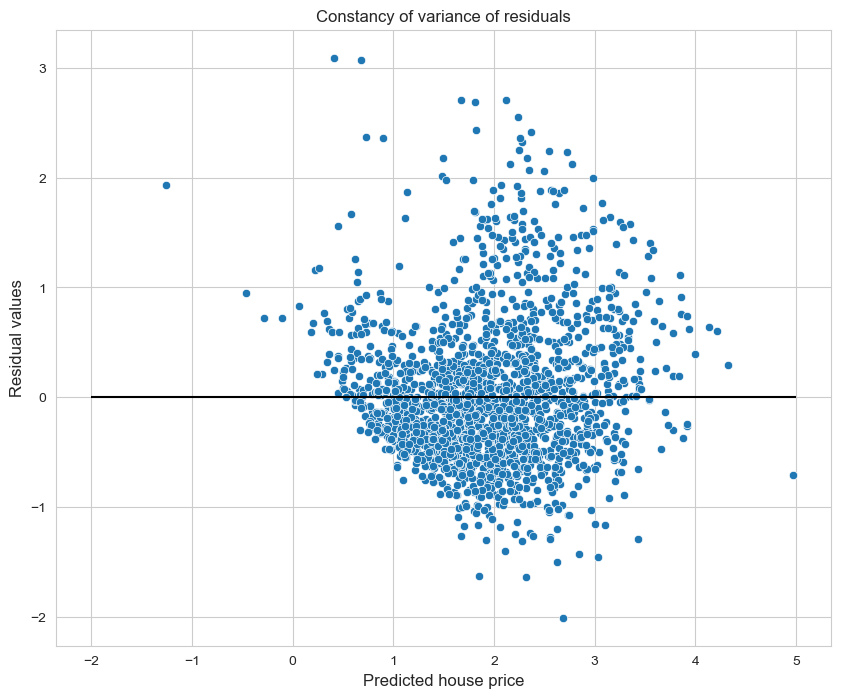

In [41]:
residues = y_test_no_max_price['MedHouseVal'] - y_pred_no_max_price
sns.scatterplot(x=y_pred_no_max_price, y=residues)
plt.hlines(0, -2, 5, color='black')
plt.title('Constancy of variance of residuals')
plt.xlabel('Predicted house price', size=12)
plt.ylabel('Residual values', size=12);

Распределение остатков в целом выглядит приемлемо.

### Анализ зависимости признаков

Зависимость признаков:

- 1 = не коррелируют.
- От 1 до 5 = умеренная корреляция.
- Более 5 = высокая корреляция.

In [42]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]

    return vif_data

calculate_vif(X)

,feature,VIF
0,MedInc,11.511140
1,HouseAge,7.195917
2,AveRooms,45.993601
3,AveBedrms,43.590314
4,Population,2.935745
5,AveOccup,1.095243
6,Latitude,559.874071
7,Longitude,633.711654


Последовательно удаляла признаки, пока VIF не стал у всех признаков менее 5.

In [43]:
calculate_vif(X.drop(['Longitude', 'AveRooms', 'Latitude'], axis=1))

,feature,VIF
0,MedInc,3.801038
1,HouseAge,3.769898
2,AveBedrms,4.263506
3,Population,2.222516
4,AveOccup,1.094644


В результате были удалены признаки Longitude, Latitude и AveRooms.

In [44]:
lin_regr_pipeline.fit(X_train_no_max_price.drop(['Longitude', 'AveRooms', 'Latitude'], axis=1), y_train_no_max_price)
y_pred_fixed = lin_regr_pipeline.predict(X_test_no_max_price.drop(['Longitude', 'AveRooms', 'Latitude'], axis=1))

In [45]:
y_pred_fixed.shape

(1965, 1)

In [46]:
y_pred_fixed = np.reshape(y_pred_fixed, (1965,), order='F')

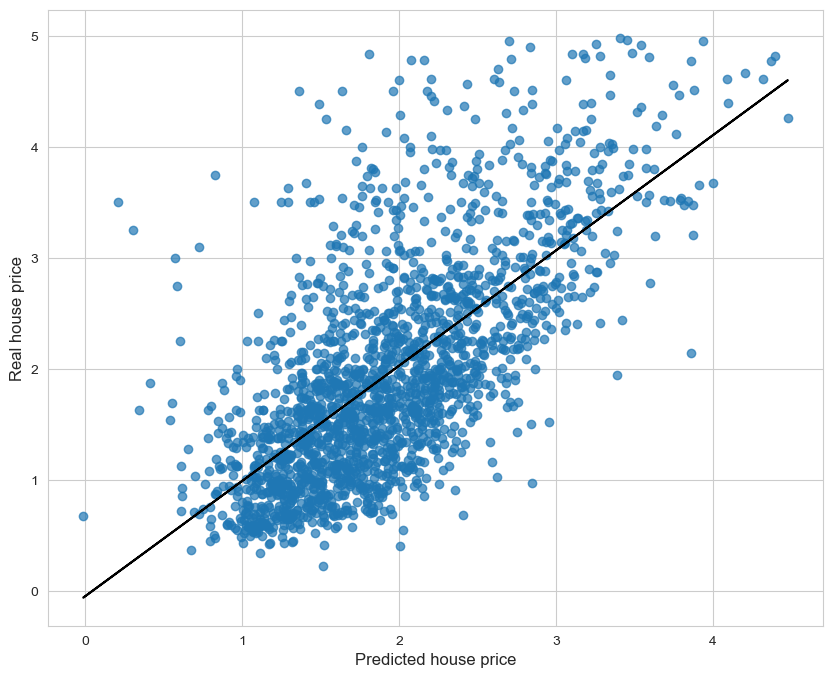

In [47]:
a, b = np.polyfit(y_pred_fixed, y_test_no_max_price['MedHouseVal'], 1)

plt.scatter(y_pred_fixed, y_test_no_max_price['MedHouseVal'], alpha=0.7) # x- predicted_price, y- real_price
plt.plot(y_pred_fixed, a * y_pred_fixed + b, color='black')
plt.xlabel('Predicted house price', size=12)
plt.ylabel('Real house price', size=12);

In [48]:
r_squared_fixed = r2_score(y_test_no_max_price['MedHouseVal'], y_pred_fixed)
mse_fixed = mean_squared_error(y_test_no_max_price['MedHouseVal'], y_pred_fixed)
print(f'R^2 = {round(r_squared_fixed, 2)}; MSE = {round(mse_fixed, 2)}')

R^2 = 0.47; MSE = 0.52


Модель стала чуть похуже, зато мы убрали зависимые переменные, которые искажали предсказание цены.

Стоит заметить, что MSE в обоих случаях (до удаления связанных признаков и после) близко к 0. Видимо, стоимость домов зависит не только от данных признаков, как-будто недостает дополнительных значимых признаков в данных.

In [49]:
X_train.drop(['Longitude', 'AveRooms', 'Latitude'], axis=1).columns

Index(['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup'], dtype='object')

In [50]:
print('Значения коэффициентов по признакам:')
counter = 0
remaining_features = ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup']
coefs = lin_regr_pipeline['regression'].coef_

for name in remaining_features:
    print(f'{name} = {coefs[0][counter]}')
    counter += 1

Значения коэффициентов по признакам:
MedInc = 0.6666241853943384
HouseAge = 0.20920060545417837
AveBedrms = 0.005837647158199892
Population = 0.050176391417179694
AveOccup = -0.047327679971667674


Наиболее значимым признаком в предсказании цены дома является __MedInc__ (от среднего дохода).

__В результате__, я бы убрала данные с максимальной ценой домов (возможно, можно для них построить свою модель), __НЕ__ убирала бы зависимые признаки (видимо, они оказывают положительный эффект напредсказание), но нужно это иметь в виду и, при необходимости, перепроверять результат.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [51]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    return 1 / (1 + np.exp(-1 * output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [52]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce_f = np.sum(-1 * (y_true * np.log(sigmoid(y_pred)) + (1 - y_true) * np.log(1 - sigmoid(y_pred)))) / y_pred.shape[0]
    return bce_f
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return X.T @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [53]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(X_test @ self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [54]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

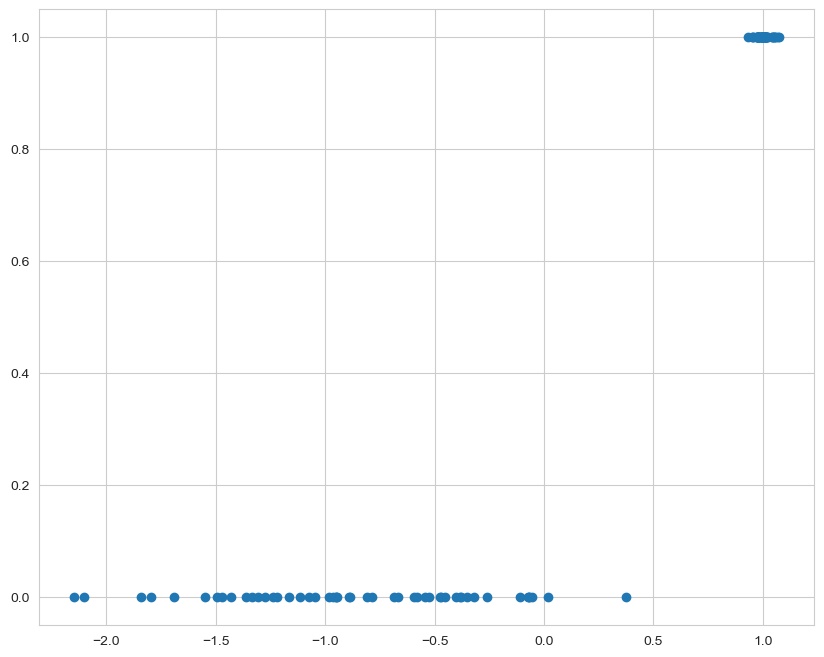

In [55]:
plt.scatter(X, y);

In [56]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

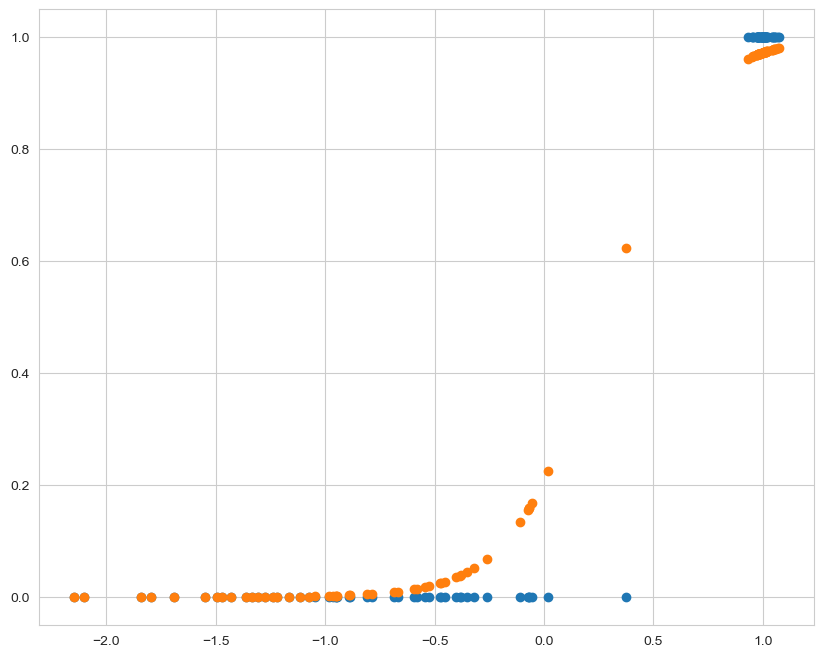

In [57]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [58]:
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

In [59]:
# accuracy, precicion, recall, f1-score

accuracy = accuracy_score(y, y_pred_binary)
precicion = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)

print(f'Accuracy score = {accuracy}')
print(f'Precicion score = {precicion}')
print(f'Recall score = {recall}')
print(f'f1 score = {f1}')

Accuracy score = 0.99
Precicion score = 0.9803921568627451
Recall score = 1.0
f1 score = 0.99009900990099


Модель хорошо классифицирует данные.

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [60]:
pokemon = pd.read_csv('../data/Pokemon.csv')
pokemon.drop(['#'], axis=1, inplace=True)
pokemon['Legendary'] = pokemon['Legendary'].astype(np.int8)
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


### EDA

In [61]:
X = pokemon.drop(['Legendary'], axis=1)
y = pokemon['Legendary']

In [62]:
X.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [63]:
X.drop(['Name', 'Type 1', 'Type 2', 'Generation'], axis=1, inplace=True)
X.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65


Разделите ваши данные на тестовую и тренировочную выборку.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    test_size=0.1)

### Обучение модели логистической регессии

Обучите модель `LogisticRegression` из `sklearn`.

In [65]:
log_reg_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression())
])

In [66]:
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int8)

In [67]:
y_test = np.array(y_test)
y_test

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int8)

### Метрики классификатора

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

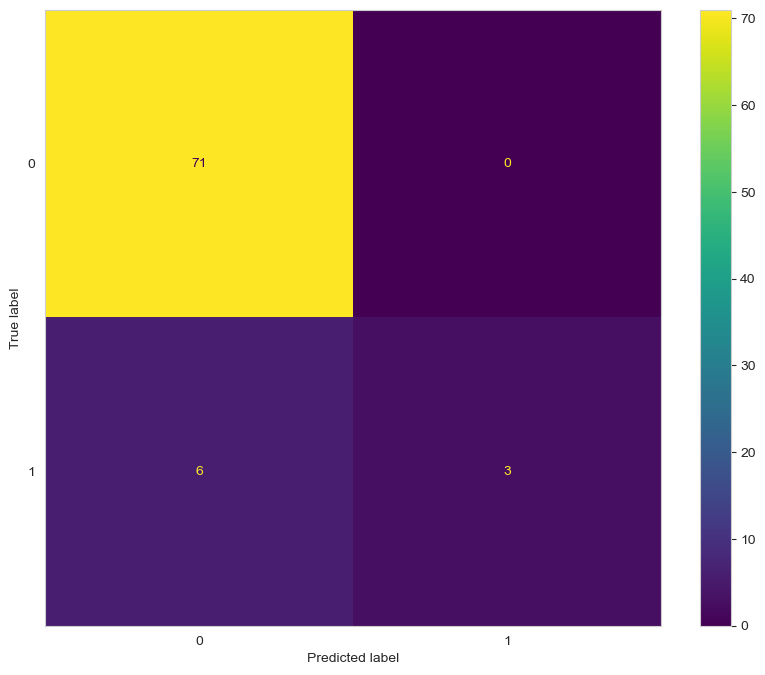

In [68]:
cm = confusion_matrix(y_test, y_pred, labels=log_reg_pipeline.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=log_reg_pipeline.classes_)

display.plot()
plt.grid(False);

TN = 71, FP = 0, FN = 6, TP = 3

In [69]:
# Predict confidence scores for samples
y_pred_decision = log_reg_pipeline.decision_function(X_test)

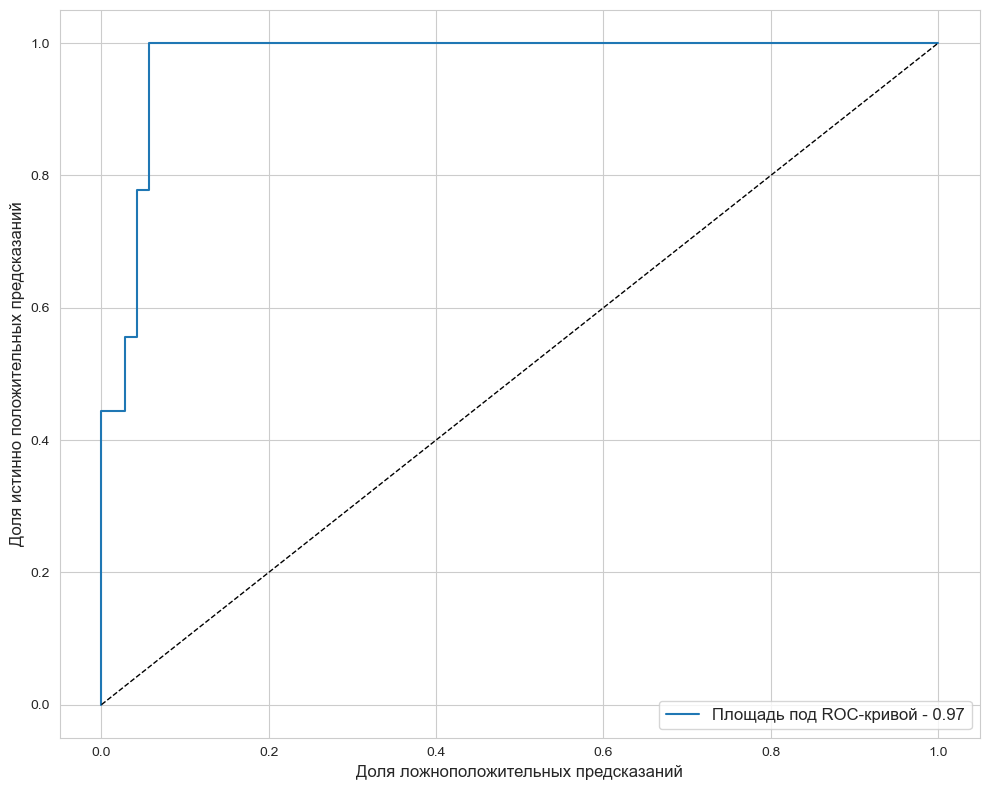

In [70]:
#plt.figure(figsize=(8,6))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_decision)
auc = round(metrics.auc(fpr, tpr), 2)


plt.plot(fpr, tpr, label=f'Площадь под ROC-кривой - {auc}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black')

plt.ylabel('Доля истинно положительных предсказаний', fontsize=12)  
plt.xlabel('Доля ложноположительных предсказаний', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()

Отличная классификация.

In [71]:
print('Значения коэффициентов по признакам:')
counter = 0
coefs = log_reg_pipeline['logistic'].coef_
for name in X.columns:
    print(f'{name} = {round(coefs[0][counter], 3)}')
    counter += 1

Значения коэффициентов по признакам:
Total = 1.05
HP = 0.514
Attack = 0.298
Defense = 0.638
Sp. Atk = 0.823
Sp. Def = 0.909
Speed = 1.034


Наибольший вклад в построение модели логистической регрессии дают: __Total__, __Speed__ и __Sp. Def__.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Последнее время слушаю [Portishead](https://music.yandex.ru/artist/16407). Вообще мне практически все песни у них нравятся (всего 3 альбома), но вот ряд приятных:

[Cowboys](https://music.yandex.ru/album/2954/track/35742)

[All mine](https://music.yandex.ru/album/2954/track/35748)

[Glory box](https://music.yandex.ru/album/87897/track/789045) - я до знакомства с группой не знала, что это их песня.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Все отлично!